In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Dataset_generation import get_dataset

%matplotlib inline
tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]

In [2]:
from Method_shiftQ import get_shiftQ_procs

exp
shiftQ Overall crossing 0


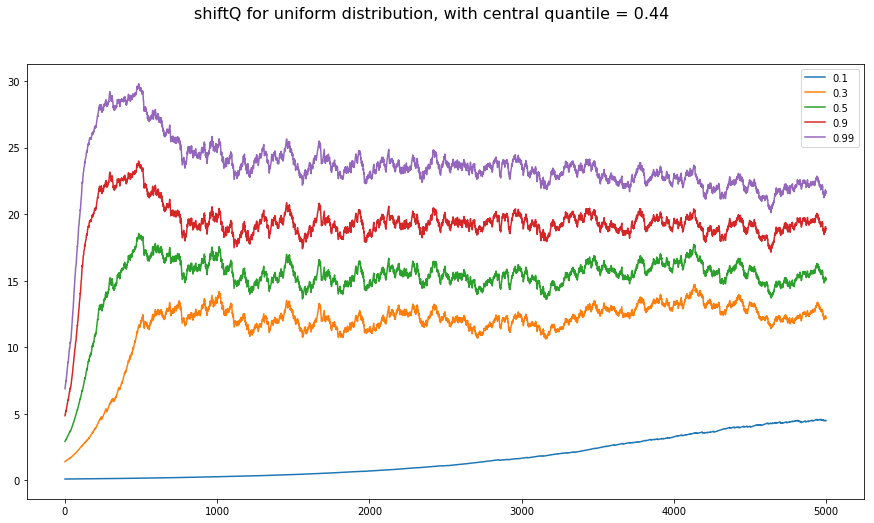

[[ 2.9229      2.9459969   2.96929248 ... 15.09441007 15.17410458
  15.04044339]
 [ 4.8571      4.9150125   4.97375036 ... 18.87787353 18.95000111
  18.80878813]
 [ 6.886502    6.98459666  7.08431229 ... 21.63854377 21.71011922
  21.56835422]]


In [9]:
dataset = get_dataset('positive exp', 5000)

proc = get_shiftQ_procs(dataset, tau_vals)
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax.plot(proc.T)
ax.legend(tau_vals)
fig.suptitle("shiftQ for uniform distribution, with central quantile = 0.44", fontsize = 16)
plt.show()

print (proc[-3:, :])

# Multi-quantile estimations

In [4]:
# Dataset generation
distros = ['mix', 'gau_1', 'gau_2', 'exp']

def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau_1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau_2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)*6.5 - 20
    else: raise Exception("distribution doesn't work!")

In [5]:
# dt = get_one_dt('exp', 10000)
# plt.hist(dt, bins=100)

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

1. Algo based on DUMIQUE (basically SGD but claim itself not ablt to deal with non-positive quantiles directly)

In [6]:
# not sure why *q_est --> Cannot deal with q_est<0
def DUMIQUE(q_est, x, tau, stepsize):
    if q_est < 0: raise Exception("!!!", q_est)
    if x > q_est:
        q_est += (stepsize*q_est)*tau
    else:
        q_est += (stepsize*q_est)*(tau-1)
    return q_est

# SGD which works for q_est non positive, only constant stepsize
def sgd(q_est, x, tau, stepsize):
    if x > q_est:
        q_est += stepsize*tau
    else:
        q_est += stepsize*(tau-1)
    return q_est

In [28]:
def checkinput(q_est):
    q_new = [-0.001]
    q_new.extend([q_est[i] for i in range(len(q_est)-1)])
    for i in range(len(q_est)):
        if q_new[i] >= q_est[i]:
#             print ("crossing at", i)
            return False
    return True

# sX is stepsize_X, sY is stepsize_Y
# c = 2 because 0.5 is at tau_vals[2]
def shiftQ(dataset, tau_lst, sX, sY, qX, qY, c=0):
    if not (checkinput(qX) and checkinput(qY)):
        raise Exception("Input quantile estimate not applicable")
    count = 0
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        qX[c] = DUMIQUE(qX[c], x, tau_lst[c], sX)

        for k in range(c-1, -1, -1):
            tau = tau_lst[k]
#           shifted observation
            yk = qX[k+1] - x
#           shifted Y distro
            qY[k] = DUMIQUE(qY[k], yk, 1-tau, sY)
#           shift back
            qX[k] = qX[k+1] - qY[k]
#             print ('yk', yk)
#             print ('qY', qY)
#             print ('qX', qX)
        
        for k in range(c+1, len(qX)):
            tau = tau_lst[k]
            yk = -qX[k-1] + x
            qY[k] = DUMIQUE(qY[k], yk, tau, sY)
            qX[k] = qX[k-1] + qY[k]
#             print ('yk',yk)
#             print ('qY', qY)
#             print ('qX', qX)
#         print ('qY', qY)
        if not (checkinput(qX)):
            count += 1
        proc[i] = qX
    print ("shiftQ Overall crossing", count)
    return proc


shiftQ Overall crossing 0


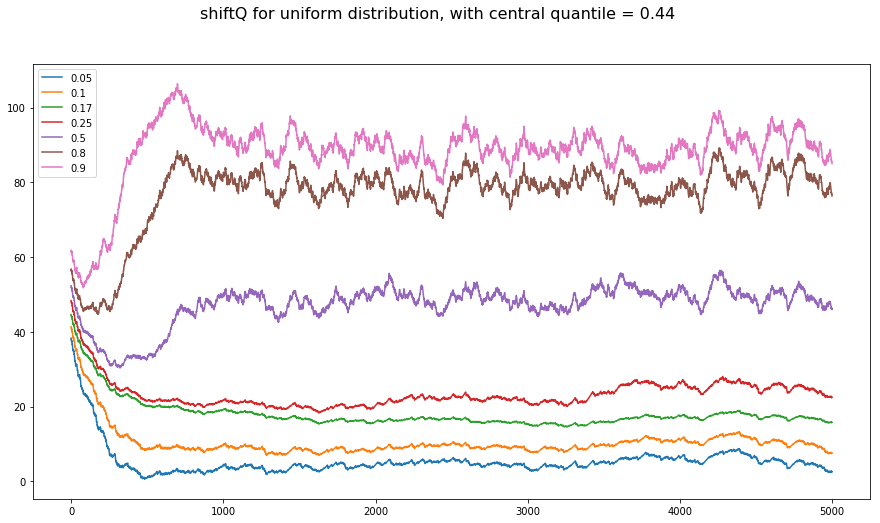

[[ 2.46932363  7.4656274  15.71289333 22.39948449 46.36102028 76.96161804
  85.6269517 ]
 [ 2.51752639  7.50883385 15.73960525 22.45962937 46.1815498  76.65974517
  85.30774816]
 [ 2.56573657  7.55205272 15.76636258 22.51998682 46.00468805 76.36097063
  84.99167762]]


In [23]:
# dataset = np.random.uniform(10, 100, 5000)
# dataset = get_dataset('positive mix', 5000)
qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
qY = np.asarray([30.0, 32, 36, 38, 40.0, 45, 50])/10.0

# qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])/10.0
# qY = np.asarray([30.0, 32, 36, 38, 40.0, 45, 50])

tau_lst = [0.05, 0.1, 0.17, 0.25, 0.5, 0.8, 0.9]
dataset = np.random.uniform(0,100, 5000)
proc = shiftQ(dataset, tau_lst, 0.01, 0.02, qX, qY, 2)
# print (proc)
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax.plot(proc)
ax.legend(tau_lst)
fig.suptitle("shiftQ for uniform distribution, with central quantile = 0.44", fontsize = 16)
plt.show()

print (proc[-3:, :])


#### Explanation

1. **Overall:** The basic idea is to estimate a central quantile point, and update other quantiles based on the central one. 

2. **Motivation:** The difference $diff$ between the two quantiles for the $x_{n}$ observation is:
$$
diff = |Q_x(q_{k+1}) - Q_x(q_k)|
$$
    Note that $diff > 0$ for all time, so different quantiles never cross each other. This property is guaranteed by the update function DUMIQE() and its restriction that the input quantile estimate must > 0.

2. **Update one quantile:** The difference is calculated based on the idea of "shift distribution". Let $X$ denotes the original distribution of data stream, and let distribution $Y$ denotes a shifted version of $X$ such that $Y = X + constant$. In this way, the quantile $q_{k+1}$ can be updated by implementation of shifting. The basic steps are:
    1. Calculate $Q_x(q_k)$, which is the shift constant
    2. Get shift observation $y_{k+1} =  Q_x(q_k) - x$
    3. Calculate the new quantile $Q_y(q_{k+1})$ in $Y$
    4. Shift the change back to $X$: $Q_x(q_{k+1}) = Q_y(q_{k+1}) + shiftConstant$

3. **Update the bigger quantiles:** Starting from central quantile $q_c$, the estimates for $q_{c+1}, ..., q_{K}$ are calculated one based on another. So each time step 2 is repeated from $q_c$ to $q_{K-1}$

4. **Update the smaller quantiles:** Similar to step 3, for smaller quantiles, estimates for $q_{c-1}, ..., q_{1}$ are calculated similarly one based on another.

#### Observation and Analysis

1. The quantiles greater than the central quantile work well. We can see the biggest 3 quantiles are converging close to the true quantiles.

2. The quantiles smaller than central quantile converges to the central quantile. Specially, the smallest quantile first converge to the second one, then the second one to the third one, until all of the small ones converge to the central one.
    
    **Explanation:**
    
    Let's assume $Q_x(q_{c-1})$ is already on it's track converging to $Q_x(q_c)$.
    On the arrival of new observation $x$, the update of $Q_x(q_{c-1})$ is 
    $$ Q_x(q_{c-1}) = Q_x(q_{c}) - Q_y(q_{c-1})$$
    We can observe from the data the difference $Q_y(q_{c-1})$ is decreasing. But I don't know why
    
    
    
    

### Comparison with SGD

In [34]:
def SGD(dataset, tau_lst, stepsize, q):
    count = 0
#     if not (checkinput(q)):
#         raise Exception("Input quantile estimate not applicable")
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        for k in range(len(tau_lst)):
            tau = tau_lst[k]
            q[k] = sgd(q[k], x, tau, stepsize)
        if not (checkinput(q)):
            count += 1
#             print ("!!! Cross !!! at", i)
        proc[i] = q
    print ("SGD overall crossings", count)
#     return proc
    return count

shiftQ Overall crossing 0
crossing at 2
!!! Cross !!! at 2400
crossing at 2
!!! Cross !!! at 2401
crossing at 2
!!! Cross !!! at 2402
crossing at 2
!!! Cross !!! at 2403
crossing at 2
!!! Cross !!! at 2404
crossing at 2
!!! Cross !!! at 2405
crossing at 2
!!! Cross !!! at 2406
crossing at 2
!!! Cross !!! at 2407
crossing at 2
!!! Cross !!! at 2408
crossing at 2
!!! Cross !!! at 2409
crossing at 2
!!! Cross !!! at 2410
crossing at 1
!!! Cross !!! at 3489
crossing at 1
!!! Cross !!! at 3490
crossing at 1
!!! Cross !!! at 3491
crossing at 1
!!! Cross !!! at 3492
crossing at 1
!!! Cross !!! at 3493
crossing at 1
!!! Cross !!! at 3494
crossing at 1
!!! Cross !!! at 3495
crossing at 1
!!! Cross !!! at 3496
crossing at 1
!!! Cross !!! at 3497
crossing at 1
!!! Cross !!! at 3498
crossing at 1
!!! Cross !!! at 3499
crossing at 1
!!! Cross !!! at 3500
crossing at 1
!!! Cross !!! at 3501
crossing at 1
!!! Cross !!! at 3502
crossing at 1
!!! Cross !!! at 3503
crossing at 1
!!! Cross !!! at 3504
cr

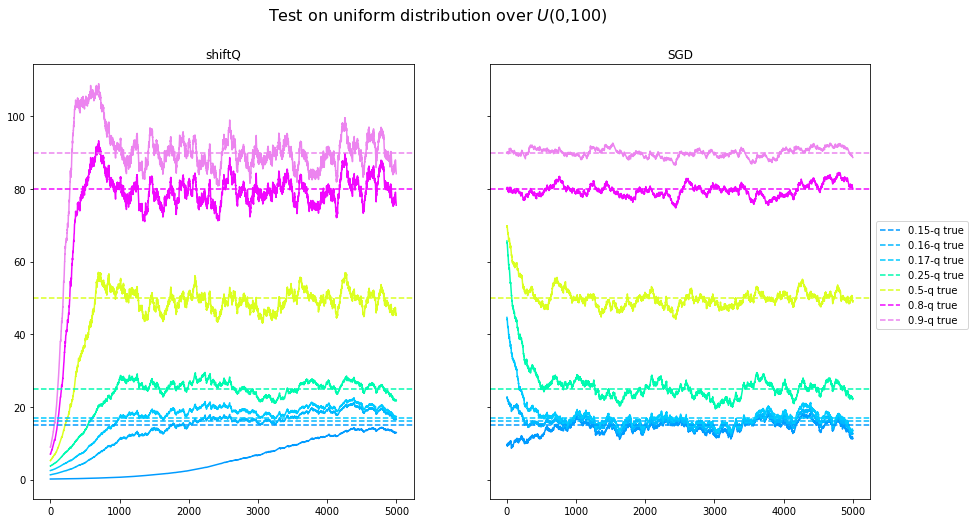

ShiftQ res [ 8.918165    9.01005339  9.10322084 ... 84.81932298 84.49577949
 84.17533905]
SGD res    [11.35 12.65 13.5  22.35 48.85 80.   88.65]
True res   [15. 16. 17. 25. 50. 80. 90.]


In [26]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

c_Norm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('gist_ncar'))

tau_lst = [0.15, 0.16, 0.17, 0.25, 0.5, 0.8, 0.9]
qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
qY = np.asarray([30.0, 32, 36, 38, 40.0, 45, 50])/10.0

# qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])/10.0
# qY = np.asarray([30.0, 32, 36, 38, 40.0, 45, 50])

# qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
# print (qX)

# proc = shiftQ(dataset, tau_lst, 0.01, 0.02, qX, qY, 2)
proc = get_shiftQ_procs(dataset, tau_lst)
proc2 = SGD(dataset, tau_lst, 0.45, qX)
q_true = np.asarray(tau_lst)*100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8), sharey=True)

for idx, qt in enumerate(q_true):
    colorVal = scalarMap.to_rgba(tau_lst[idx])                
    ax.axhline(qt, linestyle='--', color=colorVal, label=(str(tau_lst[idx])+'-q true'))
            
for i, p in enumerate(proc): 
    colorVal = scalarMap.to_rgba(tau_lst[i])
    ax1.plot(p, color=colorVal)
ax1.set_title("shiftQ")


for i, p in enumerate(proc2.T):
    colorVal = scalarMap.to_rgba(tau_lst[i])                
    ax2.plot(p, color=colorVal)
# ax2.plot(proc2)
ax2.set_title("SGD")


# print (q_true)

for i, qt in enumerate(q_true):
    colorVal = scalarMap.to_rgba(tau_lst[i])               
    ax1.axhline(qt, linestyle='--', color = colorVal, label=(str(tau_lst[i])+'-q true'))
    ax2.axhline(qt, linestyle='--', color = colorVal, label=(str(tau_lst[i])+'-q true'))

# lgd =  ([(str(t)+'-quantile') for t in tau_lst])
# ax1.legend(lgd)
lgd = ax1.legend(bbox_to_anchor=(2.47, 0.65), ncol = 1)

fig.suptitle("Test on uniform distribution over $U$(0,100)", fontsize=16)
plt.show()
fig.savefig("shiftQ_vs_SGD.png", bbox_extra_artists=[lgd, fig], bbox_inches='tight')

print ("ShiftQ res", proc[-1, :])
print ("SGD res   ", proc2[-1, :])
print ("True res  ", q_true)

In [36]:
counts = np.zeros(100)
for i in range(100):
    dataset = np.random.uniform(0,100, 5000)
    counts[i] = SGD(dataset, tau_lst, 0.45, qX)
counts

SGD overall crossings 186
SGD overall crossings 0
SGD overall crossings 0
SGD overall crossings 67
SGD overall crossings 151
SGD overall crossings 11
SGD overall crossings 0
SGD overall crossings 16
SGD overall crossings 117
SGD overall crossings 47
SGD overall crossings 5
SGD overall crossings 17
SGD overall crossings 104
SGD overall crossings 35
SGD overall crossings 231
SGD overall crossings 128
SGD overall crossings 55
SGD overall crossings 65
SGD overall crossings 5
SGD overall crossings 0
SGD overall crossings 50
SGD overall crossings 31
SGD overall crossings 105
SGD overall crossings 39
SGD overall crossings 128
SGD overall crossings 66
SGD overall crossings 153
SGD overall crossings 21
SGD overall crossings 8
SGD overall crossings 219
SGD overall crossings 70
SGD overall crossings 109
SGD overall crossings 220
SGD overall crossings 81
SGD overall crossings 0
SGD overall crossings 0
SGD overall crossings 44
SGD overall crossings 38
SGD overall crossings 65
SGD overall crossings 

array([186.,   0.,   0.,  67., 151.,  11.,   0.,  16., 117.,  47.,   5.,
        17., 104.,  35., 231., 128.,  55.,  65.,   5.,   0.,  50.,  31.,
       105.,  39., 128.,  66., 153.,  21.,   8., 219.,  70., 109., 220.,
        81.,   0.,   0.,  44.,  38.,  65., 129., 150.,  34.,  39., 192.,
        48.,   3.,  39., 284.,  62.,  55., 103.,  55.,  26.,  30.,  53.,
        95.,  33., 139.,   2.,  86.,   0., 222.,  95.,  86.,  49.,   3.,
       223.,  34.,  58., 176.,   8.,  55.,  75.,  18.,  58.,  28.,  77.,
         0., 172., 120.,  12.,  64.,  86.,  72.,  52.,  11., 113.,  72.,
         0.,  28.,   8.,  41.,   3., 213., 112.,  87.,  21.,  66.,  54.,
       232.])

In [40]:
counts.mean()
# counts.std()

72.48

Obviously SGD is better: it at least conveges to the correct value. But **crossing problem not solved**

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

Algo based on QEWA -- Too complicated, not going to implement this now


### Tracking Quantiles of Network Data Streams with Dynamic Options

Jin Cao, ...

Not going to implement this

## P2

Exponentially Weighted Simultaneous Esimation of Several Quantiles

In [9]:
def extend_tau_lst(tau_lst):
    # extend tau_lst from [tau_1, ... tau_k] to 
    # [tau_1/2, tau_1, (tau_1 + tau_k)/2]
    k = len(tau_lst)
    help_lst = np.zeros(k+2)
    for i,x in enumerate(tau_lst):
        help_lst[i+1] = x
    help_lst[-1] = 1
    
    m = k*2+1
    ext_tau_lst = np.zeros(m)
    for i in range(len(ext_tau_lst)):
        k = int(i/2)
        if i%2 == 0:
            ext_tau_lst[i] = (help_lst[k] + help_lst[k+1])*0.5
        else:
            ext_tau_lst[i] = help_lst[k+1]
            
    ext_two_lst = np.zeros(m+2)
    ext_two_lst[0] = 0
    ext_two_lst[-1] = 1
    for i, t in enumerate(ext_tau_lst):
        ext_two_lst[i+1] = t
    
    return ext_two_lst

In [10]:
def find_k(x, q_lst):
    rtn = len(q_lst)-2
    for i, q in enumerate(q_lst):
        if x < q: 
            rtn = i-1
            break
    return max(0,rtn)
        
# find_k(18.8, np.arange(3, 20))

In [11]:
def adjust_ends(lst, x):
    lst[0] = min(lst[0], x)
    lst[-1] = max(lst[-1],x)
    return lst

# adjust_ends([-1,2,3,100], 200)

In [12]:
def update_marker_lst(marker_lst, k):
    for i in range(k+1, len(marker_lst)):
        marker_lst[i] += 1
    return marker_lst
# update_marker_lst([3,45,6,7,8], 3)

In [13]:
def p2(d, q, q_m, q_p, n, n_m, n_p):
    q_new = q + d/(n_p - n_m) \
        * ((n - n_m + d) * (q_p - q)/(n_p - n)\
         + (n_p - n - d) * (q - q_m)/(n - n_m))
    return q_new

In [14]:
# main function

def ext_p2(dataset, tau_lst):
    m = 2*len(tau_lst) + 3
    
    # 0 = p1 < p2 < ... < pm = 1
    # m elements overall
    ext_tau_lst = extend_tau_lst(tau_lst)
    if (len(ext_tau_lst)!= m): raise Exception("len(ext_tau_lst)"+str(len(ext_tau_lst))+" m is "+str(m))
        
    # q1 < q2 < ... < q(m)
    # m elements overall
    ext_q_lst = np.sort(dataset[:m])
    min_x, max_x = ext_q_lst[0], ext_q_lst[-1]
    if (len(ext_q_lst)!= m): raise Exception("len(ext_q_lst)"+str(len(ext_q_lst))+" m is "+str(m))

    # current marker positions
    # n1 < n2 < ... < nm
    marker_lst = np.arange(1, m+1)
    
    # desired marker positions
    # n'1 < n'2 < ... < n'm
    # n'i = (N-1)*tau + 1, where N is the number of current observations so far
    desired_marker_lst = (m-1)*ext_tau_lst + 1
    ext_q_reco = np.zeros((len(dataset)-(m), m))
    
#     print (marker_lst, desired_marker_lst)
    
    for i, x in enumerate(dataset[m:]):
#         print ("data point number", i, ":", x)
        
        k = find_k(x, ext_q_lst)
        ext_q_lst = adjust_ends(ext_q_lst, x)
        # -------------- !!! 
        # notice the P2 paper got it wrong: 
        # in the algorithm "Box 1" PartB.2. Increment positions of markers k+1 through 5:
        # n_i += 1,   i = k,  ..., 5
        # should be   i = k+1,..., 5
        # otherwise the position of n_0 might change, which should never happen
        marker_lst = update_marker_lst(marker_lst, k)
        if marker_lst[-1] != i+1 + m or marker_lst[0] != 1: raise Exception("marker_lst wrong")
        desired_marker_lst = np.around(desired_marker_lst + ext_tau_lst, 4)

        #adjust heights of the inbetween markers n_1 ~ n_(m-2) if necessary
        for idx in range(1, m-1):
            n_p, n, n_m = marker_lst[idx+1], marker_lst[idx], marker_lst[idx-1]
            n_desire = desired_marker_lst[idx]
            d = round(n_desire - n, 2)
            
            if (d>=1 and n_p-n > 1) or (d<=-1 and n_m-n <-1):
                d = -1 if d<0 else 1
                q_m, q, q_p = ext_q_lst[idx-1], ext_q_lst[idx], ext_q_lst[idx+1] 
                
                # p2 adjustment
                q_new = p2(d, q, q_m, q_p, n, n_m, n_p)
                if q_m < q_new < q_p:
                    q = q_new
                    
                # linear adjustment
                else:
                    q2 = q_p if d>0 else q_m
                    n2 = n_p if d>0 else n_m
                    q = q + d * (q2-q)/(n2-n)
                
                ext_q_lst[idx] = q
                marker_lst[idx] = n+d
                
        ext_q_reco[i] = ext_q_lst
    return ext_q_reco

In [15]:
def get_original_lst(ext_lst):
    m = len(ext_lst)-2
    k = int((m-1)/2)
    lst = np.zeros(k)
    for i in range (1, m):
        if i % 2 == 0: 
            lst[int(i/2)-1] = ext_lst[i]
            
    return lst

In [16]:
def test(tau_lst):
    print (extend_tau_lst(tau_lst))
    dt = np.random.normal(-20, 0.001, 2000)
#     dt = np.append(dt, np.random.uniform(20, 60, 2000))
    L = len((extend_tau_lst(tau_lst)))
    q_true=np.percentile(dt, np.array(tau_lst) * 100)
    q_lst= ext_p2(dt, tau_lst)
    return q_true, q_lst.T

tau_lst = [0.001, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
true_q, q_res = test(tau_lst)
print (true_q)

[0.000e+00 5.000e-04 1.000e-03 5.500e-03 1.000e-02 3.000e-02 5.000e-02
 7.500e-02 1.000e-01 1.750e-01 2.500e-01 3.750e-01 5.000e-01 6.250e-01
 7.500e-01 8.250e-01 9.000e-01 9.250e-01 9.500e-01 9.700e-01 9.900e-01
 9.945e-01 9.990e-01 9.995e-01 1.000e+00]
[-20.00332154 -20.00225722 -20.00161907 -20.00126823 -20.00063275
 -19.99998868 -19.99929654 -19.99870008 -19.99834012 -19.99781933
 -19.99713541]


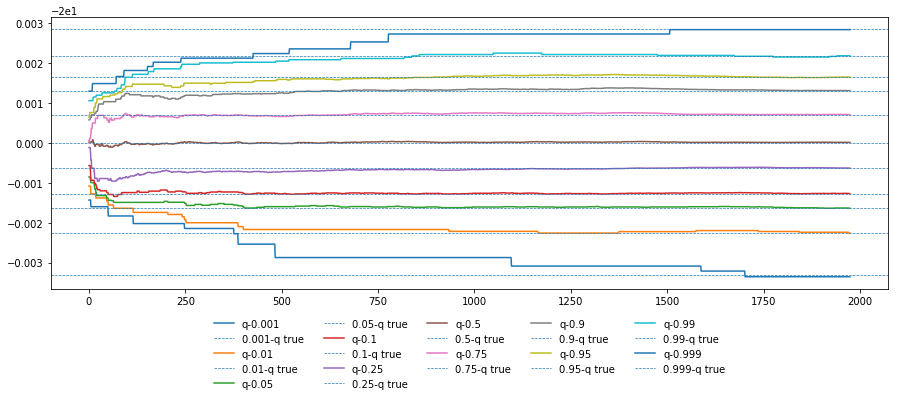

In [17]:
ext_tau_lst = np.round(extend_tau_lst(tau_lst), 4)

fig, (ax2) = plt.subplots(1, 1, figsize = (15, 5))
for i in range(len(tau_lst)):
    ax2.plot(q_res[(i+1)*2], label = 'q-{}'.format(tau_lst[i]))
    ax2.axhline(true_q[i], linestyle='--',linewidth = 0.7, label=(str(tau_lst[i])+'-q true'))
lgd = ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
            frameon=False, ncol=5)
plt.show()
fig.savefig("P2_std_001.png")